In [1]:
import tensorflow as tf
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import err_checks
import tensorflow_benchmarking

In [2]:
%matplotlib inline

# Distribution Plots

In [3]:
def generate_coherent_states(N, alpha):
    displs = tf.cast(tf.linspace(tf.constant(0, dtype=tf.float32), np.pi, 100), dtype=tf.complex64)
    displs = tf.map_fn(lambda theta: np.abs(alpha) * tf.math.exp(1j * theta), displs)
    analytic = err_checks.coherent_analytic(N, displs)

    vac = tf.cast(tf.one_hot(0, N), dtype=tf.complex64)
        
    _, bch_op = tensorflow_benchmarking.eager_benchmark_BCH(N, displs, '/device:CPU:0', rep=1)
    numeric_bch = tf.linalg.matvec(bch_op, vac)
    
    _, op = tensorflow_benchmarking.eager_benchmark(N, displs, '/device:CPU:0', rep=1)
    numeric = tf.linalg.matvec(op, vac)
    
    return analytic, numeric_bch, numeric

In [4]:
def log_abs_err(test, ref):
    abs_err = tf.math.abs(test - ref)
    log_abs_err = tf.math.log(abs_err) / tf.math.log(10.)
    return abs_err, log_abs_err

In [106]:
def plot_abs_err(N, alpha):
    analytic, numeric_bch, numeric = generate_coherent_states(N, alpha)

    _, n_err = log_abs_err(numeric, analytic)
    _, nbch_err = log_abs_err(numeric_bch, analytic)

    comb = tf.concat([n_err, nbch_err], axis=0)
    vmax = tf.reduce_max(tf.boolean_mask(comb, tf.math.is_finite(comb)))
    vmin = tf.reduce_min(tf.boolean_mask(comb, tf.math.is_finite(comb)))

    fig = plt.figure(figsize=(15, 9))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(224)

    im1 = ax1.imshow(n_err, interpolation='nearest', aspect=0.5 * N / 100, vmin=vmin, vmax=vmax)
    im2 = ax2.imshow(nbch_err, interpolation='nearest', aspect=0.5 * N / 100, vmin=vmin, vmax=vmax)
    fig.colorbar(im1, ax=[ax1, ax2])
    ax1.set_title('Expm')
    ax2.set_title('BCH')

    proba = tf.reduce_mean(tf.cast(tf.math.conj(analytic) * analytic, dtype=tf.float32), axis=0)
    probn = tf.reduce_mean(tf.cast(tf.math.conj(numeric) * numeric, dtype=tf.float32), axis=0)
    probbch = tf.reduce_mean(tf.cast(tf.math.conj(numeric_bch) * numeric_bch, dtype=tf.float32), axis=0)
    ax0.plot(proba, label='Analytic')
    ax0.plot(probn, label='Expm')
    ax0.plot(probbch, label='BCH')
    ax0.set_yscale("log")
    ax0.set_ylabel('Log Prob')
    ax0.legend()
    fig.suptitle('N = %i, α = %i' % (N, alpha), y=0.92, fontsize=16)

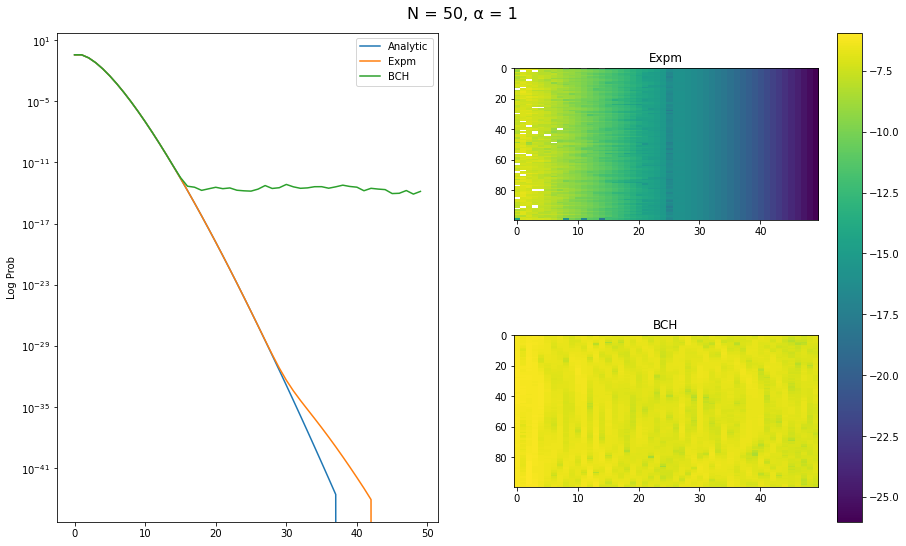

In [107]:
plot_abs_err(50, 1)

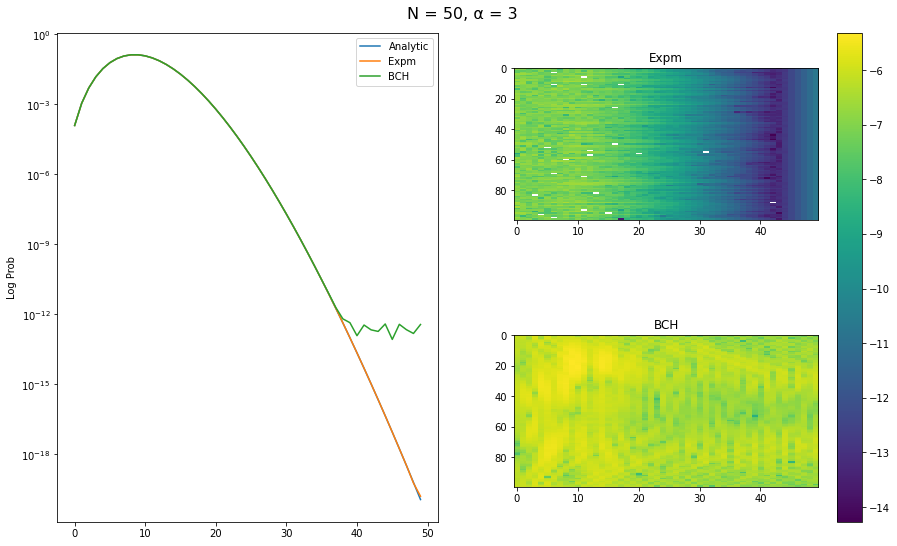

In [108]:
plot_abs_err(50, 3)

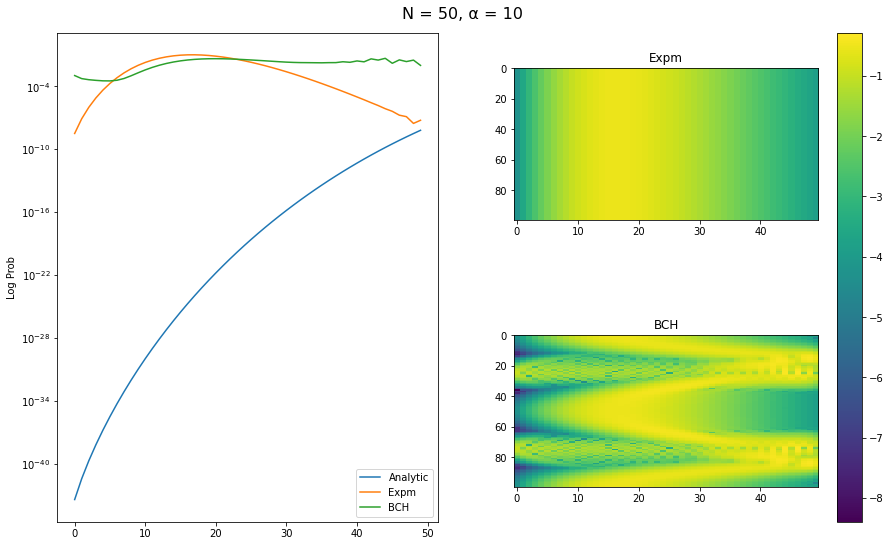

In [109]:
plot_abs_err(50, 10)

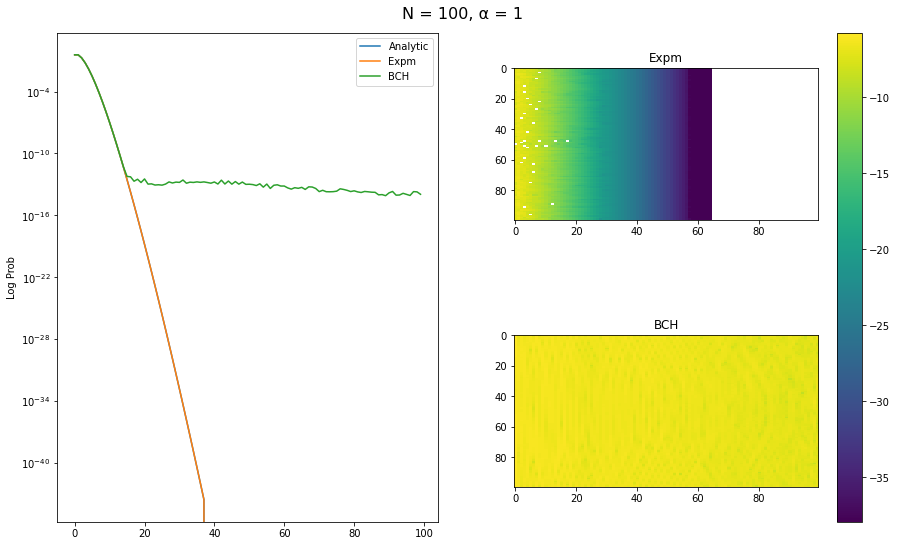

In [110]:
plot_abs_err(100, 1)

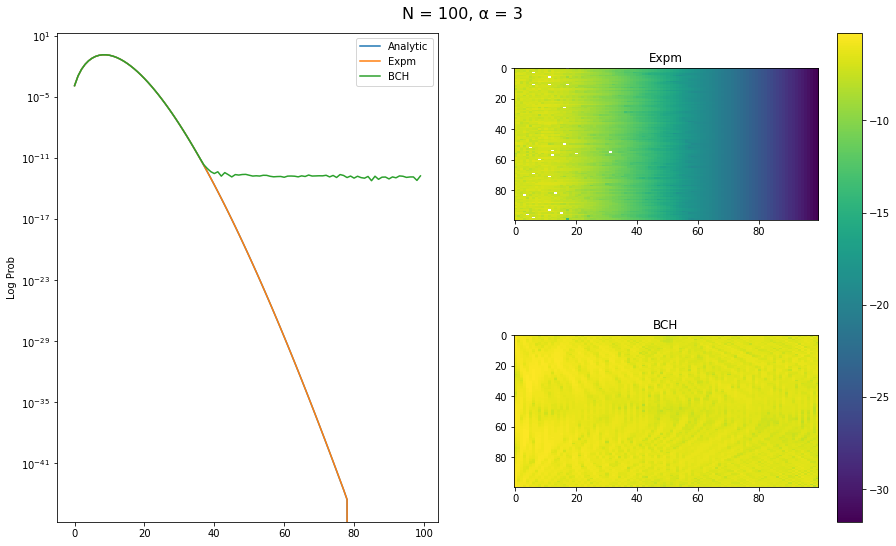

In [111]:
plot_abs_err(100, 3)

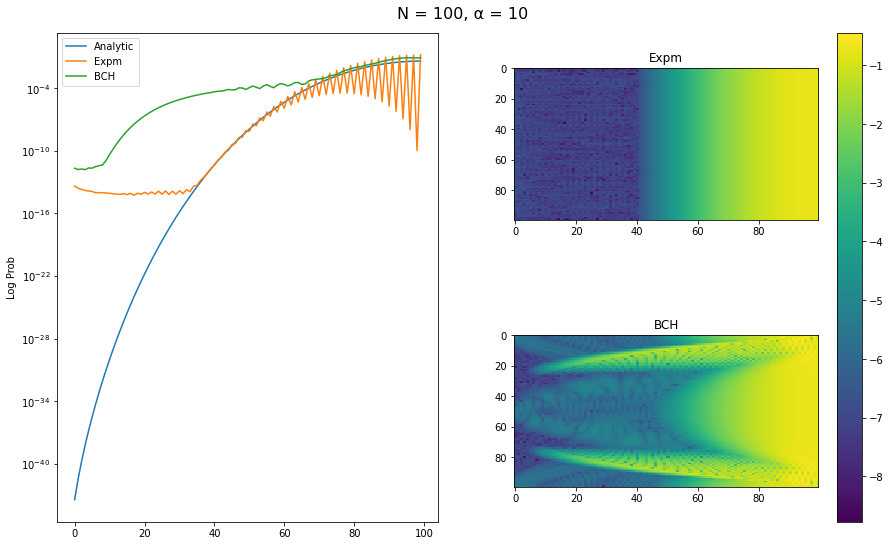

In [112]:
plot_abs_err(100, 10)

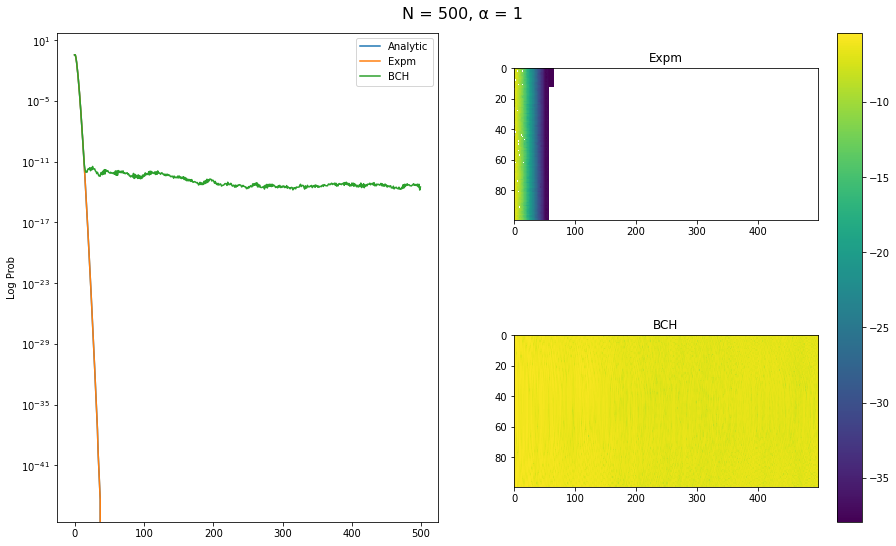

In [113]:
plot_abs_err(500, 1)

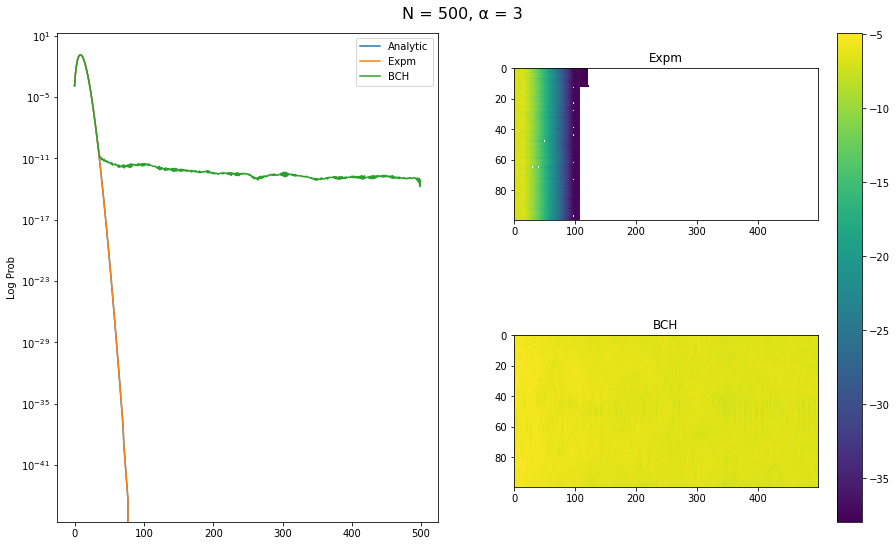

In [114]:
plot_abs_err(500, 3)

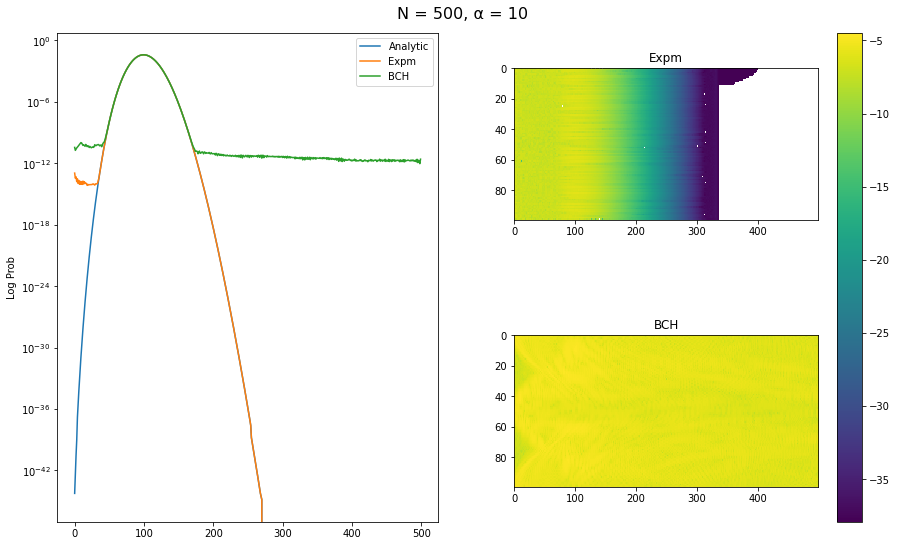

In [115]:
plot_abs_err(500, 10)